#### Downloading The Dataset
Here, we download our dataset using the `gdown` command, which fetches the dataset from a given Google Drive link. This step is crucial to obtain the data required for training and validating our model.


In [5]:
! gdown 1jOwJSUTO5A2IK9pPofcLsh5Btf_kfJS7

Downloading...
From (original): https://drive.google.com/uc?id=1jOwJSUTO5A2IK9pPofcLsh5Btf_kfJS7
From (redirected): https://drive.google.com/uc?id=1jOwJSUTO5A2IK9pPofcLsh5Btf_kfJS7&confirm=t&uuid=1988c756-32d8-44f3-a989-2913b11c88e1
To: /content/facial_expressions.zip
100% 69.4M/69.4M [00:01<00:00, 39.5MB/s]


#### Setting up libraries, modules & dataset
In this section, we start by importing necessary libraries and modules. TensorFlow and Keras are used for building our deep learning model. We also install and import Gradio to create an interactive interface for our model.
We extract the dataset from a zip file and list its contents to verify successful extraction.
Paths for training and validation data are defined, and key parameters such as batch size and image dimensions are set.
We use `ImageDataGenerator` to apply data augmentation techniques to our training data, enhancing the model's ability to generalize. For the validation data, we simply rescale the images to normalize them.
Data generators are created to load images from the directories, apply augmentations, and prepare them for training and validation. This ensures the model receives data in the correct format and size.


In [6]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
!pip install gradio
import gradio as gr

# Extracting the dataset
with zipfile.ZipFile("facial_expressions.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")
os.listdir('/content/dataset')

# Paths and other more input parameters
train_data_path = '/content/dataset/facial_expressions/train'
val_data_path = '/content/dataset/facial_expressions/validation'
batch_size = 32
img_height = 224
img_width = 224
num_classes = 6

# Data augmentation for training and normalization for validation
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_data_generator = ImageDataGenerator(rescale=1./255)

#Creating data generators
train_generator = train_data_generator.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = validation_data_generator.flow_from_directory(
    val_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existin

#### Setting up & training the model
In this section, we load the pre-trained EfficientNetB0 model without its top classification layer. This allows us to leverage its feature extraction capabilities.
Custom layers are added on top of the base model. A global average pooling layer reduces the spatial dimensions of the features. Dense layers with ReLU activation are added for further processing, and an output layer with softmax activation is included for multi-class classification.
The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.
Several callbacks are defined: EarlyStopping to halt training if no improvement in validation loss is observed, ModelCheckpoint to save the best model, and ReduceLROnPlateau to reduce the learning rate if the validation loss plateaus.
The model is trained using the training and validation data generators, and the defined callbacks are applied to monitor and adjust the training process.
After training, the final model is saved to a file for later use.


In [7]:
# EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Custom layers on EfficientNetB0
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('efficientnetb0_best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]
# Training
history = model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator,
    callbacks=callbacks
)
model.save('efficientnetb0_final_model.keras')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


801/801 ━━━━━━━━━━━━━━━━━━━━ 405s 401ms/step - accuracy: 0.4395 - loss: 1.3848 - val_accuracy: 0.5663 - val_loss: 1.1581 - learning_rate: 0.0010
Epoch 2/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 266s 330ms/step - accuracy: 0.5793 - loss: 1.0701 - val_accuracy: 0.6066 - val_loss: 1.0284 - learning_rate: 0.0010
Epoch 3/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 266s 329ms/step - accuracy: 0.6115 - loss: 0.9987 - val_accuracy: 0.6121 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 4/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 266s 329ms/step - accuracy: 0.6380 - loss: 0.9414 - val_accuracy: 0.6294 - val_loss: 0.9771 - learning_rate: 0.0010
Epoch 5/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 266s 329ms/step - accuracy: 0.6476 - loss: 0.9204 - val_accuracy: 0.6588 - val_loss: 0.8996 - learning_rate: 0.0010
Epoch 6/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 265s 328ms/step - accuracy: 0.6566 - loss: 0.8930 - val_accuracy: 0.6317 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 7/15
801/801 ━━━━━━━━━━━━━━━━━━━━ 266s 329ms/step - accuracy: 0.6657 

#### Accessing the model
Finally, we set up Gradio to create an interactive web interface for our model. This interface allows users to upload images and get real-time predictions on facial expressions.
The input image is resized to match the model's expected input dimensions, normalized, and expanded to include a batch dimension.
The model makes a prediction on the processed image, and the class with the highest probability is selected.
The predicted class label is returned to the user.
Gradio launches the interface, making the model accessible and easy to use in a real-world application.


In [8]:
# Gradio setup
def face_expression_predict(img):
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction)
    class_labels = list(train_generator.class_indices.keys())
    return class_labels[class_idx]
faceexpapp = gr.Interface(fn=face_expression_predict, inputs=gr.Image(type="pil"), outputs="text")
faceexpapp .launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://badc80a08680769ea9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#### Training History Visualization
In this section, we plot the training and validation accuracy and loss curves. These plots help us understand how well the model is learning and if it is overfitting or underfitting.
- We use matplotlib to plot these graphs. The accuracy and loss are plotted for each epoch, showing both training and validation metrics.


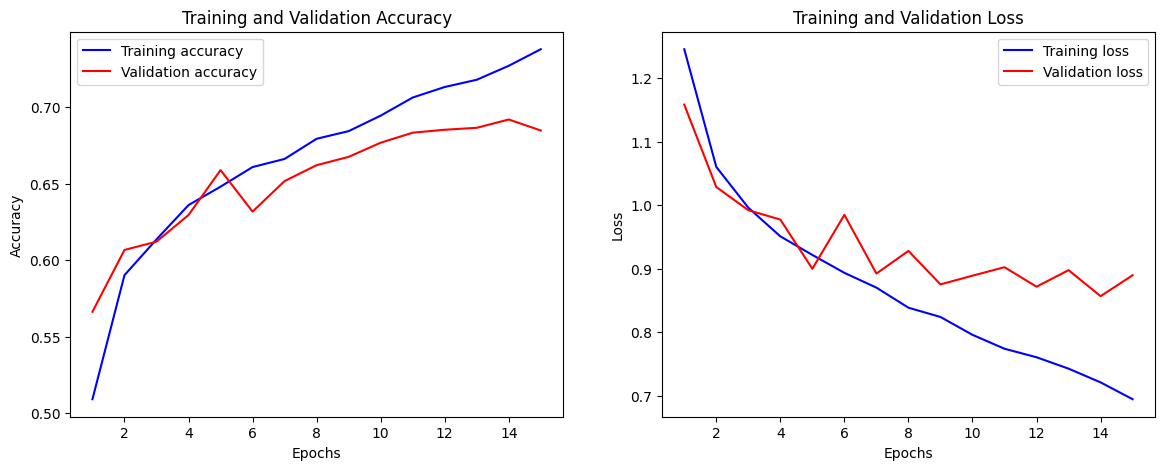

In [9]:
import matplotlib.pyplot as plot

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plot.figure(figsize=(14, 5))
    plot.subplot(1, 2, 1)
    plot.plot(epochs, acc, 'b', label='Training accuracy')
    plot.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plot.title('Training and Validation Accuracy')
    plot.xlabel('Epochs')
    plot.ylabel('Accuracy')
    plot.legend()
    plot.subplot(1, 2, 2)
    plot.plot(epochs, loss, 'b', label='Training loss')
    plot.plot(epochs, val_loss, 'r', label='Validation loss')
    plot.title('Training and Validation Loss')
    plot.xlabel('Epochs')
    plot.ylabel('Loss')
    plot.legend()
    plot.show()
plot_training_history(history)


#### Classification Report and Confusion Matrix
Here, we generate a classification report and confusion matrix to evaluate the performance of our model on the validation set.
- The classification report provides precision, recall, and F1-score for each class.
- The confusion matrix helps us visualize the true positives, false positives, true negatives, and false negatives.


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
print('Confusion Matrix')
confmtx = confusion_matrix(validation_generator.classes, y_pred)
print(confmtx)

196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step
Classification Report
              precision    recall  f1-score   support

       anger       0.17      0.20      0.19       960
     disgust       0.02      0.01      0.01       111
        fear       0.15      0.11      0.12      1018
   happiness       0.29      0.30      0.30      1825
     neutral       0.20      0.27      0.23      1216
     sadness       0.17      0.14      0.15      1139

    accuracy                           0.21      6269
   macro avg       0.17      0.17      0.17      6269
weighted avg       0.21      0.21      0.21      6269

Confusion Matrix
[[193   6  98 281 224 158]
 [ 17   1  15  34  25  19]
 [185  11 107 299 259 157]
 [332  18 221 544 461 249]
 [215   9 139 346 331 176]
 [180  10 126 345 321 157]]


#### ROC Curve and AUC for Each Class
Here, we calculate and plot the ROC curve and AUC for each class individually. This helps in assessing the model's performance across different classes.
- We initialize a dictionary `roc_auc` to store the AUC for each class.
- `roc_auc_score` calculates the AUC for each class by treating each class as a binary classification task.
- We print the ROC AUC score for each class and plot the ROC curves to visualize the model's performance.

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
ROC AUC Score: 0 (anger): 0.5082289508381993
ROC AUC Score: 1 (disgust): 0.5156779871784744
ROC AUC Score: 2 (fear): 0.48860886821445554
ROC AUC Score: 3 (happiness): 0.5005589805555898
ROC AUC Score: 4 (neutral): 0.5024059931827888
ROC AUC Score: 5 (sadness): 0.4811348315183627


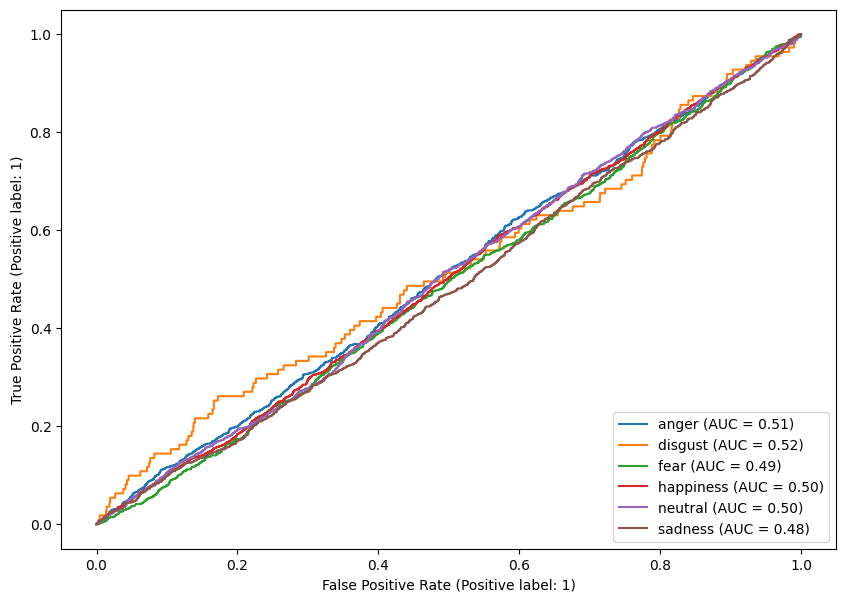

In [11]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

Y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
target_names = list(train_generator.class_indices.keys())
n_classes = num_classes
roc_auc = {}
for i in range(n_classes):
    roc_auc[i] = roc_auc_score(y_true == i, Y_pred[:, i])
for i in range(n_classes):
    print(f'ROC AUC Score: {i} ({target_names[i]}): {roc_auc[i]}')
fig, ax = plot.subplots(figsize=(10, 7))
for i in range(n_classes):
    RocCurveDisplay.from_predictions(y_true == i, Y_pred[:, i], name=target_names[i], ax=ax)
plot.show()


#### Video Generation
In this section we set the paths for the validation images and the output directory for the labelled images. We then compile the images into a video.

In [ ]:
import os
import random
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import tensorflow as tf

# Loading the model
model = tf.keras.models.load_model('efficientnetb0_final_model.keras')

# Image paths
validation_path = '/content/dataset/facial_expressions/validation'
output_path = 'annotated_images'
os.makedirs(output_path, exist_ok=True)

# Image dimensions
img_height = 224
img_width = 224
emotions = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
def label_images():
    all_images = []
    for emotion in emotions:
        emotion_folder = os.path.join(validation_path, emotion)
        for filename in os.listdir(emotion_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                all_images.append(os.path.join(emotion_folder, filename))
    for img_path in all_images:
        img = Image.open(img_path).convert('RGB').resize((img_width, img_height))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        emotion = emotions[class_idx]
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("calibri.ttf", 56)
        except IOError:
            font = ImageFont.load_default()
        text = f"Emotion: {emotion}"
        text_size = draw.textbbox((0, 0), text, font=font)[2:]
        text_x = (img.width - text_size[0]) / 2
        draw.text((text_x, 10), text, font=font, fill="red")
        img.save(os.path.join(output_path, os.path.basename(img_path)))
        print(f"Annotated image saved at: {os.path.basename(img_path)}")
label_images()

# Create a video from the annotated images
def make_video(image_folder, video_name, fps=2):
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")])
    if not images:
        print("No images found in the specified directory.")
        return
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))
    cv2.destroyAllWindows()
    video.release()
make_video(output_path, 'efficientnetb0-face.mp4')
